# 1. Setting up the Kaggle NoteBook.

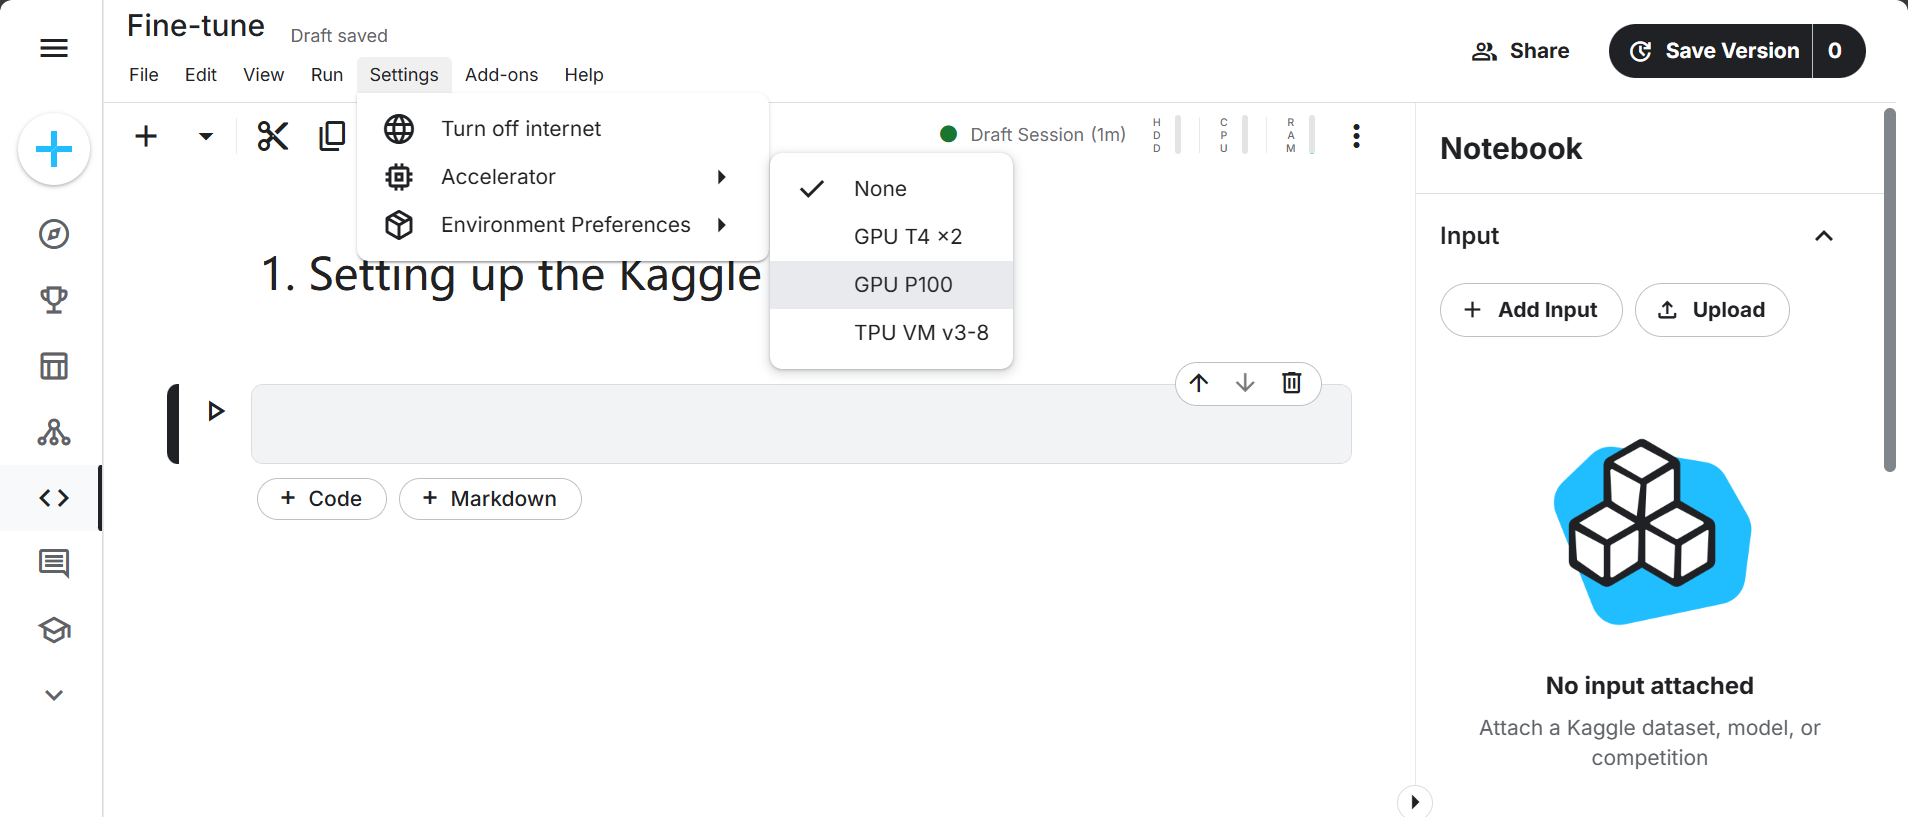

# 2. Install required libraries

In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy==1.13.0 einops evaluate trl rouge_score pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 112.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.5/450.5 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.

## Loading the required libraries

In [4]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [7]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

# 3. Loading dataset

In this instance, we will utilize the DialogSum DataSet from HuggingFace for the fine-tuning process. DialogSum is an extensive dialogue summarization dataset, featuring 13,460 dialogues along with manually labeled summaries and topics.

In [8]:
from datasets import load_dataset
dataset = load_dataset("neil-code/dialogsum-test")

README.md:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/441k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/447k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/499 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/499 [00:00<?, ? examples/s]

In [9]:
#a sample row of the dataset
dataset['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

# 4. Create Bitsandbytes configuration

To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll be using BitsAndBytesConfig to load our model in 4-bit format. This will reduce memory consumption considerably, at a cost of some accuracy.

In [10]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )

# 5. Loading the Pre-Trained model

Meta open-sourced the Llama-3.2-3B-Instruct, a Small Language Model(SLM) with 3 billion parameters. Here, we will use Llama-3.2-3B-Instruct for the fine-tuning process. This language model exhibits remarkable reasoning and language understanding capabilities, achieving state-of-the-art performance among base language models.

Let’s now load Llama-3.2-3B-Instruct using 4-bit quantization from HuggingFace.

In [12]:
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  n


The model is loaded in 4-bit using the `BitsAndBytesConfig` from the bitsandbytes library. This is a part of the QLoRA process, which involves quantizing the pre-trained weights of the model to 4-bit and keeping them fixed during fine-tuning.

In [13]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM


model_name="meta-llama/Llama-3.2-3B-Instruct"
device_map = {"": 0}
original_model = AutoModelForCausalLM.from_pretrained(model_name, 
                                                      device_map=device_map,
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      token=True).to(device)

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

# 6. Tokenization

Now, let’s configure the tokenizer, incorporating left-padding to optimize memory usage during training.

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [15]:
print_gpu_utilization()

GPU memory occupied: 2704 MB.


In [16]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [17]:
def gen(model,p, maxlen=100, sample=True):
    toks = eval_tokenizer(p, return_tensors="pt")
    res = model.generate(**toks.to("cuda"), max_new_tokens=maxlen, do_sample=sample,num_return_sequences=1,temperature=0.1,num_beams=1,top_p=0.95,).to('cpu')
    return eval_tokenizer.batch_decode(res,skip_special_tokens=True)

# 7. Test the Model with Zero Shot Inferencing

We will evaluate the base model that we loaded above using a few sample inputs.

In [20]:
import logging

# Set the logging level to ERROR so that WARNING-level messages are not displayed
logging.getLogger("transformers").setLevel(logging.ERROR)

#%%time
from transformers import set_seed
seed = 42
set_seed(seed)

index = 10

prompt = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

formatted_prompt = f"Instruct: Summarize the following conversation.\n{prompt}\nOutput:\n"
res = gen(original_model,formatted_prompt,100,)
#print(res[0])
output = res[0].split('Output:\n')[1]

dash_line = '-'.join('' for x in range(90))
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

-----------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

-----------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday party. Brian thinks #P

# 8. Pre-processing dataset

In [21]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters 
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"
    
    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"
    
    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

The above function can be used to convert our input into prompt format.

Now, we will use our model tokenizer to process these prompts into tokenized ones.

Our aim here is to generate input sequences with consistent lengths, which is beneficial for fine-tuning the language model by optimizing efficiency and minimizing computational overhead. It is essential to ensure that these sequences do not surpass the model’s maximum token limit.

In [22]:
from functools import partial

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """
    
    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)
    
    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'topic', 'dialogue', 'summary'],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)
    
    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [24]:
print_gpu_utilization()

GPU memory occupied: 2846 MB.


By utilizing these functions, our dataset will be prepared for the fine-tuning process!


In [25]:
## Pre-process dataset
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['train'])
eval_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['validation'])

Found max lenth: 131072
131072
Preprocessing dataset...


Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1999 [00:00<?, ? examples/s]

Preprocessing dataset...


In [26]:
print(f"Shapes of the datasets:")
print(f"Training: {train_dataset.shape}")
print(f"Validation: {eval_dataset.shape}")
print(train_dataset)

Shapes of the datasets:
Training: (1999, 3)
Validation: (499, 3)
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 1999
})


# 9. Preparing the model for QLoRA

Here, the model is prepared for QLoRA training using the `prepare_model_for_kbit_training()` function. This function initializes the model for QLoRA by setting up the necessary configurations.

In [27]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
# Using the prepare_model_for_kbit_training method from PEFT
# Preparing the Model for QLoRA
original_model = prepare_model_for_kbit_training(original_model)

# 10. Setup PEFT for Fine-Tuning

Define the LoRA config for Fine-tuning the base model.

In [28]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=32, #Rank
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

peft_model = get_peft_model(original_model, config)

Once everything is set up and the PEFT is prepared, we can use the `print_trainable_parameters()` helper function to see how many trainable parameters are in the model.

In [29]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"


In [30]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 12845056
all model parameters: 1816308736
percentage of trainable model parameters: 0.71%


In [31]:
# See how the model looks different now, with the LoRA adapters added:
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

# 11. Train PEFT Adapter

Define training arguments and create Trainer instance.

In [33]:
output_dir = './peft-dialogue-summary-training/final-checkpoint'
import transformers

peft_training_args = TrainingArguments(
    output_dir = output_dir,
    warmup_steps=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=1000,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=25,
    logging_dir="./logs",
    save_strategy="steps",
    save_steps=25,
    eval_strategy="steps",
    eval_steps=25,
    do_eval=True,
    gradient_checkpointing=True,
    report_to="none",
    overwrite_output_dir = 'True',
    group_by_length=True,
)

peft_model.config.use_cache = False

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [34]:
peft_training_args.device

device(type='cuda', index=0)

In [35]:
peft_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.8664, 'grad_norm': 0.5530906319618225, 'learning_rate': 0.0001951951951951952, 'epoch': 0.05002501250625312}
{'eval_loss': 1.6047710180282593, 'eval_runtime': 136.219, 'eval_samples_per_second': 3.663, 'eval_steps_per_second': 0.462, 'epoch': 0.05002501250625312}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.363, 'grad_norm': 0.584343433380127, 'learning_rate': 0.0001901901901901902, 'epoch': 0.10005002501250625}
{'eval_loss': 1.6222995519638062, 'eval_runtime': 139.3642, 'eval_samples_per_second': 3.581, 'eval_steps_per_second': 0.452, 'epoch': 0.10005002501250625}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.6131, 'grad_norm': 0.36472415924072266, 'learning_rate': 0.0001851851851851852, 'epoch': 0.1500750375187594}
{'eval_loss': 1.566935658454895, 'eval_runtime': 137.8681, 'eval_samples_per_second': 3.619, 'eval_steps_per_second': 0.457, 'epoch': 0.1500750375187594}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.3644, 'grad_norm': 0.5614725351333618, 'learning_rate': 0.00018018018018018018, 'epoch': 0.2001000500250125}
{'eval_loss': 1.5700678825378418, 'eval_runtime': 138.1824, 'eval_samples_per_second': 3.611, 'eval_steps_per_second': 0.456, 'epoch': 0.2001000500250125}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5825, 'grad_norm': 0.37864741683006287, 'learning_rate': 0.0001751751751751752, 'epoch': 0.25012506253126565}
{'eval_loss': 1.5523096323013306, 'eval_runtime': 137.6081, 'eval_samples_per_second': 3.626, 'eval_steps_per_second': 0.458, 'epoch': 0.25012506253126565}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.3045, 'grad_norm': 0.6815304160118103, 'learning_rate': 0.0001701701701701702, 'epoch': 0.3001500750375188}
{'eval_loss': 1.5657129287719727, 'eval_runtime': 137.5682, 'eval_samples_per_second': 3.627, 'eval_steps_per_second': 0.458, 'epoch': 0.3001500750375188}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5475, 'grad_norm': 0.3762545883655548, 'learning_rate': 0.00016516516516516518, 'epoch': 0.3501750875437719}
{'eval_loss': 1.5473905801773071, 'eval_runtime': 138.6946, 'eval_samples_per_second': 3.598, 'eval_steps_per_second': 0.454, 'epoch': 0.3501750875437719}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.2895, 'grad_norm': 0.6255953907966614, 'learning_rate': 0.00016016016016016018, 'epoch': 0.400200100050025}
{'eval_loss': 1.546990156173706, 'eval_runtime': 138.3919, 'eval_samples_per_second': 3.606, 'eval_steps_per_second': 0.455, 'epoch': 0.400200100050025}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5985, 'grad_norm': 0.5404505133628845, 'learning_rate': 0.00015515515515515516, 'epoch': 0.4502251125562781}
{'eval_loss': 1.5416945219039917, 'eval_runtime': 136.5603, 'eval_samples_per_second': 3.654, 'eval_steps_per_second': 0.461, 'epoch': 0.4502251125562781}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.3534, 'grad_norm': 0.5630851984024048, 'learning_rate': 0.00015015015015015014, 'epoch': 0.5002501250625313}
{'eval_loss': 1.5317972898483276, 'eval_runtime': 139.71, 'eval_samples_per_second': 3.572, 'eval_steps_per_second': 0.451, 'epoch': 0.5002501250625313}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.6053, 'grad_norm': 0.4245665967464447, 'learning_rate': 0.00014514514514514515, 'epoch': 0.5502751375687844}
{'eval_loss': 1.529371738433838, 'eval_runtime': 136.5624, 'eval_samples_per_second': 3.654, 'eval_steps_per_second': 0.461, 'epoch': 0.5502751375687844}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.2784, 'grad_norm': 0.6449844837188721, 'learning_rate': 0.00014014014014014013, 'epoch': 0.6003001500750376}
{'eval_loss': 1.5212990045547485, 'eval_runtime': 138.7491, 'eval_samples_per_second': 3.596, 'eval_steps_per_second': 0.454, 'epoch': 0.6003001500750376}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5615, 'grad_norm': 0.4574141800403595, 'learning_rate': 0.00013513513513513514, 'epoch': 0.6503251625812907}
{'eval_loss': 1.5103477239608765, 'eval_runtime': 139.4951, 'eval_samples_per_second': 3.577, 'eval_steps_per_second': 0.452, 'epoch': 0.6503251625812907}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.314, 'grad_norm': 0.728701114654541, 'learning_rate': 0.00013013013013013014, 'epoch': 0.7003501750875438}
{'eval_loss': 1.5022704601287842, 'eval_runtime': 138.4111, 'eval_samples_per_second': 3.605, 'eval_steps_per_second': 0.455, 'epoch': 0.7003501750875438}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5301, 'grad_norm': 0.4989340007305145, 'learning_rate': 0.00012512512512512512, 'epoch': 0.7503751875937968}
{'eval_loss': 1.5043389797210693, 'eval_runtime': 136.4627, 'eval_samples_per_second': 3.657, 'eval_steps_per_second': 0.462, 'epoch': 0.7503751875937968}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.287, 'grad_norm': 0.6634334325790405, 'learning_rate': 0.00012012012012012013, 'epoch': 0.80040020010005}
{'eval_loss': 1.5105037689208984, 'eval_runtime': 136.9231, 'eval_samples_per_second': 3.644, 'eval_steps_per_second': 0.46, 'epoch': 0.80040020010005}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5625, 'grad_norm': 0.4251130521297455, 'learning_rate': 0.00011511511511511512, 'epoch': 0.8504252126063031}
{'eval_loss': 1.5076671838760376, 'eval_runtime': 139.577, 'eval_samples_per_second': 3.575, 'eval_steps_per_second': 0.451, 'epoch': 0.8504252126063031}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.3042, 'grad_norm': 0.6795079708099365, 'learning_rate': 0.00011011011011011012, 'epoch': 0.9004502251125562}
{'eval_loss': 1.5003368854522705, 'eval_runtime': 138.6882, 'eval_samples_per_second': 3.598, 'eval_steps_per_second': 0.454, 'epoch': 0.9004502251125562}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5829, 'grad_norm': 0.40772560238838196, 'learning_rate': 0.00010510510510510511, 'epoch': 0.9504752376188094}
{'eval_loss': 1.4989069700241089, 'eval_runtime': 138.7636, 'eval_samples_per_second': 3.596, 'eval_steps_per_second': 0.454, 'epoch': 0.9504752376188094}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.2699, 'grad_norm': 0.6548337936401367, 'learning_rate': 0.00010010010010010012, 'epoch': 1.0}
{'eval_loss': 1.5034780502319336, 'eval_runtime': 137.8746, 'eval_samples_per_second': 3.619, 'eval_steps_per_second': 0.457, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.485, 'grad_norm': 0.4168050289154053, 'learning_rate': 9.50950950950951e-05, 'epoch': 1.0500250125062531}
{'eval_loss': 1.5004942417144775, 'eval_runtime': 137.9184, 'eval_samples_per_second': 3.618, 'eval_steps_per_second': 0.457, 'epoch': 1.0500250125062531}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.2182, 'grad_norm': 0.6398261189460754, 'learning_rate': 9.009009009009009e-05, 'epoch': 1.1000500250125063}
{'eval_loss': 1.4994534254074097, 'eval_runtime': 137.8147, 'eval_samples_per_second': 3.621, 'eval_steps_per_second': 0.457, 'epoch': 1.1000500250125063}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5169, 'grad_norm': 0.4355441629886627, 'learning_rate': 8.50850850850851e-05, 'epoch': 1.1500750375187594}
{'eval_loss': 1.4998416900634766, 'eval_runtime': 137.5934, 'eval_samples_per_second': 3.627, 'eval_steps_per_second': 0.458, 'epoch': 1.1500750375187594}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.202, 'grad_norm': 0.6400514245033264, 'learning_rate': 8.008008008008009e-05, 'epoch': 1.2001000500250125}
{'eval_loss': 1.5011115074157715, 'eval_runtime': 139.1009, 'eval_samples_per_second': 3.587, 'eval_steps_per_second': 0.453, 'epoch': 1.2001000500250125}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.512, 'grad_norm': 0.4671444594860077, 'learning_rate': 7.507507507507507e-05, 'epoch': 1.2501250625312657}
{'eval_loss': 1.5000792741775513, 'eval_runtime': 139.4909, 'eval_samples_per_second': 3.577, 'eval_steps_per_second': 0.452, 'epoch': 1.2501250625312657}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.2812, 'grad_norm': 0.7122857570648193, 'learning_rate': 7.007007007007007e-05, 'epoch': 1.3001500750375188}
{'eval_loss': 1.499498963356018, 'eval_runtime': 138.4075, 'eval_samples_per_second': 3.605, 'eval_steps_per_second': 0.455, 'epoch': 1.3001500750375188}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.501, 'grad_norm': 0.4894965887069702, 'learning_rate': 6.506506506506507e-05, 'epoch': 1.350175087543772}
{'eval_loss': 1.4931304454803467, 'eval_runtime': 137.1348, 'eval_samples_per_second': 3.639, 'eval_steps_per_second': 0.459, 'epoch': 1.350175087543772}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.2515, 'grad_norm': 0.6262324452400208, 'learning_rate': 6.0060060060060066e-05, 'epoch': 1.400200100050025}
{'eval_loss': 1.4939378499984741, 'eval_runtime': 137.4614, 'eval_samples_per_second': 3.63, 'eval_steps_per_second': 0.458, 'epoch': 1.400200100050025}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.4576, 'grad_norm': 0.49802446365356445, 'learning_rate': 5.505505505505506e-05, 'epoch': 1.4502251125562782}
{'eval_loss': 1.493026614189148, 'eval_runtime': 136.8002, 'eval_samples_per_second': 3.648, 'eval_steps_per_second': 0.461, 'epoch': 1.4502251125562782}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.1705, 'grad_norm': 0.6416962742805481, 'learning_rate': 5.005005005005006e-05, 'epoch': 1.5002501250625313}
{'eval_loss': 1.4964853525161743, 'eval_runtime': 137.8614, 'eval_samples_per_second': 3.62, 'eval_steps_per_second': 0.457, 'epoch': 1.5002501250625313}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5024, 'grad_norm': 0.5001025199890137, 'learning_rate': 4.5045045045045046e-05, 'epoch': 1.5502751375687844}
{'eval_loss': 1.4944615364074707, 'eval_runtime': 137.8962, 'eval_samples_per_second': 3.619, 'eval_steps_per_second': 0.457, 'epoch': 1.5502751375687844}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.1949, 'grad_norm': 0.6771126985549927, 'learning_rate': 4.0040040040040046e-05, 'epoch': 1.6003001500750376}
{'eval_loss': 1.4926058053970337, 'eval_runtime': 138.0985, 'eval_samples_per_second': 3.613, 'eval_steps_per_second': 0.456, 'epoch': 1.6003001500750376}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5199, 'grad_norm': 0.5605615973472595, 'learning_rate': 3.503503503503503e-05, 'epoch': 1.6503251625812907}
{'eval_loss': 1.4923046827316284, 'eval_runtime': 137.0551, 'eval_samples_per_second': 3.641, 'eval_steps_per_second': 0.46, 'epoch': 1.6503251625812907}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.1927, 'grad_norm': 0.6818145513534546, 'learning_rate': 3.0030030030030033e-05, 'epoch': 1.7003501750875438}
{'eval_loss': 1.4933379888534546, 'eval_runtime': 137.7551, 'eval_samples_per_second': 3.622, 'eval_steps_per_second': 0.457, 'epoch': 1.7003501750875438}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.4929, 'grad_norm': 0.4811195731163025, 'learning_rate': 2.502502502502503e-05, 'epoch': 1.750375187593797}
{'eval_loss': 1.4904334545135498, 'eval_runtime': 139.2414, 'eval_samples_per_second': 3.584, 'eval_steps_per_second': 0.452, 'epoch': 1.750375187593797}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.1864, 'grad_norm': 0.6873822212219238, 'learning_rate': 2.0020020020020023e-05, 'epoch': 1.80040020010005}
{'eval_loss': 1.4920856952667236, 'eval_runtime': 138.4182, 'eval_samples_per_second': 3.605, 'eval_steps_per_second': 0.455, 'epoch': 1.80040020010005}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.4974, 'grad_norm': 0.5763280391693115, 'learning_rate': 1.5015015015015016e-05, 'epoch': 1.8504252126063032}
{'eval_loss': 1.4908028841018677, 'eval_runtime': 138.5333, 'eval_samples_per_second': 3.602, 'eval_steps_per_second': 0.455, 'epoch': 1.8504252126063032}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.2089, 'grad_norm': 0.6507307887077332, 'learning_rate': 1.0010010010010011e-05, 'epoch': 1.9004502251125563}
{'eval_loss': 1.4897081851959229, 'eval_runtime': 137.6622, 'eval_samples_per_second': 3.625, 'eval_steps_per_second': 0.458, 'epoch': 1.9004502251125563}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.5166, 'grad_norm': 0.5087106227874756, 'learning_rate': 5.005005005005006e-06, 'epoch': 1.9504752376188095}
{'eval_loss': 1.4913016557693481, 'eval_runtime': 137.8816, 'eval_samples_per_second': 3.619, 'eval_steps_per_second': 0.457, 'epoch': 1.9504752376188095}


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 1.223, 'grad_norm': 0.7461214065551758, 'learning_rate': 0.0, 'epoch': 2.0}
{'eval_loss': 1.4900321960449219, 'eval_runtime': 137.4453, 'eval_samples_per_second': 3.631, 'eval_steps_per_second': 0.458, 'epoch': 2.0}
{'train_runtime': 9816.2673, 'train_samples_per_second': 0.407, 'train_steps_per_second': 0.102, 'train_loss': 1.4077425575256348, 'epoch': 2.0}


TrainOutput(global_step=1000, training_loss=1.4077425575256348, metrics={'train_runtime': 9816.2673, 'train_samples_per_second': 0.407, 'train_steps_per_second': 0.102, 'train_loss': 1.4077425575256348, 'epoch': 2.0})

In [36]:
print_gpu_utilization()

GPU memory occupied: 15070 MB.


In [37]:
# Free memory for merging weights
del original_model
del peft_trainer
torch.cuda.empty_cache()

In [38]:
print_gpu_utilization()

GPU memory occupied: 3560 MB.


Once the model is trained successfully, we can use it for inference. Let’s now prepare the inference model by adding an adapter to the original Phi-2 model. Here, we are setting is_trainable=False because the plan is only to perform inference with this PEFT model.

In [39]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "meta-llama/Llama-3.2-3B-Instruct"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, 
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      token=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [40]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [42]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/kaggle/working/peft-dialogue-summary-training/final-checkpoint/checkpoint-1000",torch_dtype=torch.float16,is_trainable=False)

# 12. Evaluate the Model Quantitatively (with ROUGE Metric)

In [43]:
original_model = AutoModelForCausalLM.from_pretrained(base_model_id, 
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      token=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [44]:
import pandas as pd

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"
    
    original_model_res = gen(original_model,prompt,100,)
    original_model_text_output = original_model_res[0].split('Output:\n')[1]
    
    peft_model_res = gen(ft_model,prompt,100,)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    #print(peft_model_output)
    peft_model_text_output, success, result = peft_model_output.partition('#End')
    

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,"Attention all staff... Effective immediately, ...",#Person1# instructs Ms. Dawson to take a dicta...
1,In order to prevent employees from wasting tim...,"Attention all staff... Effective immediately, ...",#Person1# instructs Ms. Dawson to take a dicta...
2,Ms. Dawson takes a dictation for #Person1# abo...,"Attention all staff... Effective immediately, ...",#Person1# instructs Ms. Dawson to take a dicta...
3,#Person2# arrives late because of traffic jam....,Person1: You're finally here! What took so lon...,#Person1# and #Person2# talk about #Person2#'s...
4,#Person2# decides to follow #Person1#'s sugges...,Person1: You're finally here! What took so lon...,#Person2# got stuck in traffic and #Person1# s...
5,#Person2# complains to #Person1# about the tra...,Person1: You're finally here! What took so lon...,#Person2# got stuck in traffic and #Person1# s...
6,#Person1# tells Kate that Masha and Hero get d...,Instruct: Summarize the news about Masha and H...,#Person1# tells Kate that Masha and Hero are g...
7,#Person1# tells Kate that Masha and Hero are g...,Instruct: Summarize the news about Masha and H...,#Person1# tells Kate that Masha and Hero are g...
8,#Person1# and Kate talk about the divorce betw...,Instruct: Summarize the news about Masha and H...,#Person1# tells Kate that Masha and Hero are g...
9,#Person1# and Brian are at the birthday party ...,"Happy Birthday, this is for you, Brian.\nI'm s...",Brian invites #Person1# to the party and they ...


In [46]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.22645774405656174, 'rouge2': 0.06903767636681793, 'rougeL': 0.17010417457803628, 'rougeLsum': 0.1617719459253228}
PEFT MODEL:
{'rouge1': 0.32697876092377065, 'rouge2': 0.11256963615824775, 'rougeL': 0.24228038227652307, 'rougeLsum': 0.25081974723095046}


In [47]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 10.05%
rouge2: 4.35%
rougeL: 7.22%
rougeLsum: 8.90%
